# Detect High Data Drift 
<b>With this tutorial you:</b><br />
Understand how to use Eurybia to detect datadrift

Contents:
- Detect data drift  
- Compile Drift over years

This public dataset comes from :

https://www.kaggle.com/sobhanmoosavi/us-accidents/version/10

---
Acknowledgements
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.
---

In this tutorial, the data are not loaded raw, a data preparation to facilitate the use of the tutorial has been done. You can find it here : 
https://github.com/MAIF/eurybia/blob/master/eurybia/data/dataprep_US_car_accidents.ipynb

**Requirements notice** : the following tutorial may use third party modules not included in Eurybia.  
You can find them all in one file [on our Github repository](https://github.com/MAIF/eurybia/blob/master/requirements.dev.txt) or you can manually install those you are missing, if any.

In [1]:
import pandas as pd
from category_encoders import OrdinalEncoder
import catboost
from eurybia import SmartDrift
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

## Import Dataset and split in training and production dataset

In [2]:
from eurybia.data.data_loader import data_loading

In [3]:
df_car_accident = pd.read_csv('../../eurybia/data/US_Accidents_extract.csv')

In [4]:
df_car_accident.head()

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Visibility(mi),Wind_Direction,Weather_Condition,day_of_week_acc,Nautical_Twilight,season_acc,cible,year_acc
0,37.5,-122.3,0.0,73.0,44.0,10.0,0.112071,Fair,3,Day,autumn,0,2020
1,33.4,-112.6,0.0,59.0,55.0,10.0,0.175655,Fair,5,Night,spring,0,2020
2,28.0,-82.3,1.0,77.0,89.0,10.0,0.172628,Cloudy,1,Night,autumn,0,2020
3,33.1,-117.3,1.0,69.0,11.0,10.0,0.195514,Fair,0,Night,winter,0,2020
4,39.8,-86.0,0.0,43.0,81.0,10.0,0.145093,Fair,6,Day,winter,0,2020


In [5]:
df_car_accident.shape

(31935, 13)

In [6]:
# Let us consider that the column "year_acc" corresponds to the reference date. 
#In 2016, a model was trained using data. And in next years, we want to detect data drift on new data in production to predict
df_accident_baseline = df_car_accident.loc[df_car_accident['year_acc'] == 2016]
df_accident_2017 = df_car_accident.loc[df_car_accident['year_acc'] == 2017]
df_accident_2018 = df_car_accident.loc[df_car_accident['year_acc'] == 2018]
df_accident_2019 = df_car_accident.loc[df_car_accident['year_acc'] == 2019]
df_accident_2020 = df_car_accident.loc[df_car_accident['year_acc'] == 2020]

In [7]:
#We will train a classification model to predict the severity of an accident. 0 for a less severe accident and 1 for a severe accident.
#Let's check percentage in class 0 and 1
pd.crosstab(df_car_accident.year_acc, df_car_accident.cible, normalize = 'index')*100

cible,0,1
year_acc,,
2016,71.331283,28.668717
2017,68.273017,31.726983
2018,66.641250,33.358750
2019,79.600182,20.399818
2020,90.525000,9.475000


In [8]:
y_df_learning=df_accident_baseline['cible'].to_frame()
X_df_learning=df_accident_baseline[df_accident_baseline.columns.difference(['cible','year_acc'])]

y_df_2017=df_accident_2017['cible'].to_frame()
X_df_2017=df_accident_2017[df_accident_2017.columns.difference(['cible','year_acc'])]

y_df_2018=df_accident_2018['cible'].to_frame()
X_df_2018=df_accident_2018[df_accident_2018.columns.difference(['cible','year_acc'])]

y_df_2019=df_accident_2019['cible'].to_frame()
X_df_2019=df_accident_2019[df_accident_2019.columns.difference(['cible','year_acc'])]

y_df_2020=df_accident_2020['cible'].to_frame()
X_df_2020=df_accident_2020[df_accident_2020.columns.difference(['cible','year_acc'])]



## Building Supervized Model

In [9]:
features = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Visibility(mi)', 'Wind_Direction',
       'Weather_Condition', 'day_of_week_acc', 'Nautical_Twilight',
       'season_acc']

In [ ]:
features_to_encode = [col for col in X_df_learning[features].columns if X_df_learning[col].dtype not in ('float64','int64')]

encoder = OrdinalEncoder(cols=features_to_encode)
encoder = encoder.fit(X_df_learning[features])

X_df_learning_encoded=encoder.transform(X_df_learning)

In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_df_learning_encoded, y_df_learning, train_size=0.75, random_state=1)

In [12]:
train_pool_cat = catboost.Pool(data=Xtrain, label= ytrain, cat_features = features_to_encode)
test_pool_cat = catboost.Pool(data=Xtest, label= ytest, cat_features = features_to_encode)

In [40]:
model = catboost.CatBoostClassifier(loss_function= "Logloss", eval_metric="Logloss",
                                    learning_rate=0.143852,
                                    iterations=300,
                                    l2_leaf_reg=15,
                                    max_depth = 4,
                                    use_best_model=True,
                                    custom_loss=['Accuracy', 'AUC', 'Logloss'])

model = model.fit(train_pool_cat, plot=True,eval_set=test_pool_cat, verbose=0)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [14]:
proba = model.predict_proba(Xtest)
print(metrics.roc_auc_score(ytest,proba[:,1]))

0.7689429564506236


## Use Eurybia for data validation

In [15]:
from eurybia import SmartDrift

In [16]:
SD = SmartDrift(df_current=X_df_2017,
                df_baseline=X_df_learning,
                deployed_model=model, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [17]:
%time 
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = '01/01/2017', # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "car_accident_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )
                 

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 16.9 µs
The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.6459837259371833
car_accident_auc.csv did not exist and is created. 


As soon as compile() method, Eurybia displays default consistency checks as warnings.<br />
If some modalities are not present during training and are in production dataset, the deployed model will consider them wrongly.<br />
Inversely, if some modalities are present during training and are not in production dataset, it means that some profiles are missing.

In [18]:
SD.generate_report(    
    output_file='report_car_accident_datadrift_2017.html',    
    title_story="Data drift",
    title_description="""Car accident Data drift 2017""", # Optional: add a subtitle to describe report
    project_info_file="../../eurybia/data/project_info_car_accident.yml" # Optional: add information on report
    )

Report saved to ./report_car_accident_datadrift_2017.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.

Eurybia is designed to generate an HTML report for analysis, and less for use in notebook mode. 
However, to illustrate functionalities, we will detail results with notebook mode analysis.

## First Analysis of results of the data drift

Data driftn methodology is based on the ability of a model to discriminate whether an individual belongs to one of the two datasets.
For this purpose a target 0 is assigned to the baseline dataset and a target 1 to the current dataset.
Then a classification model (catboost) is learned to predict this target.
The level of capacity of the data drift classifier to detect if an individual belongs to one of the 2 datasets represents the level of difference between the 2 datasets

### Detection data drift performance

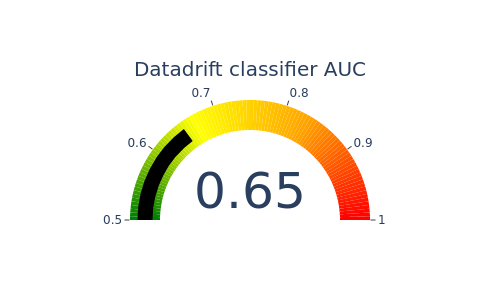

In [19]:
#Performance of datadrift classifier
SD.plot.generate_indicator(fig_value=SD.auc, height=300, width=500, title="Datadrift classifier AUC")

An Auc close to 0.5 means that there is little drift

### Importance of features in data drift

This graph represents the variables in the data drift classification model that are most important to differentiate between the two datasets.

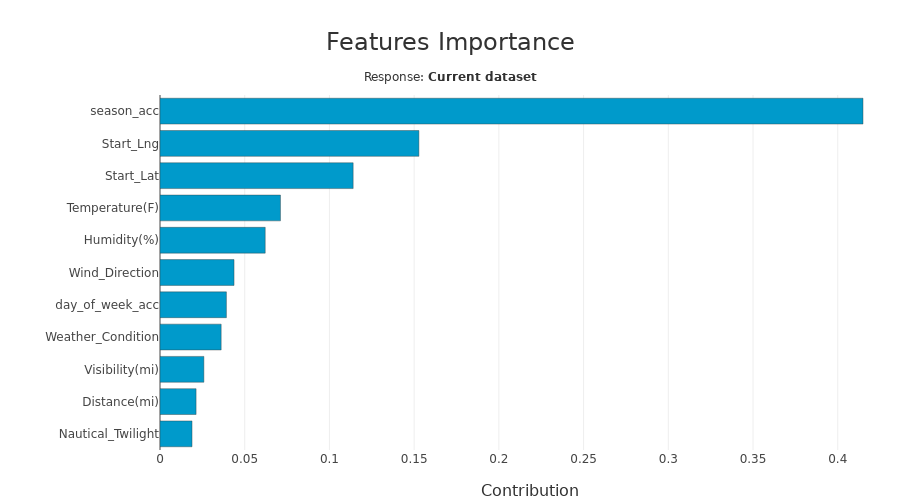

In [20]:
SD.xpl.plot.features_importance()

We get the features with most gaps, those that are most important to analyse.
With date bias introduced, it is normal that date features are the most impacted. We will then decide to remove them.
Let's analyse other important variables

### Feature importance overview

This graph compares the importance of variables between the data drift classifier model and the deployed model. This allows us to put into perspective the importance of data drift in relation to the impacts to be expected on the deployed model. If the variable is at the top left, it means that the variable is very important for data drift classification, but that the variable has little influence on the deployed model. If the variable is at the bottom right, it means that the variable has little importance for data drift classification, and that the variable has a lot of influence on the deployed model.

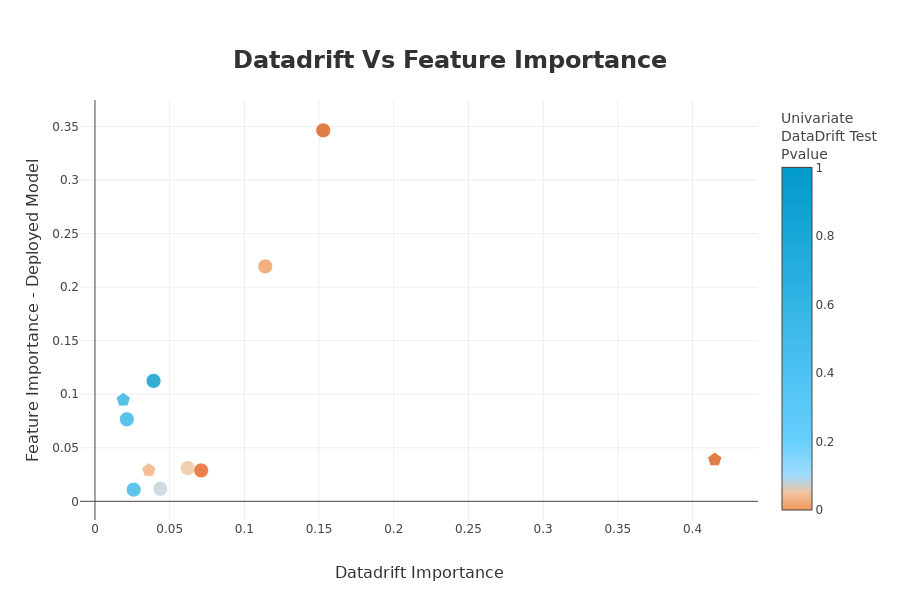

In [21]:
SD.plot.scatter_feature_importance() # works if deployed_model is filled

Putting importance of the drift into perspective according to the importance of the model to be deployed, can help the data scientist to validate that his model can be deployed. <br />


### Univariate analysis

This graphs shows a particular feature's distribution over its possible values. In the drop-down menu, the variables are sorted by importance of the variables in the data drift classification. For categorical features, the possible values are sorted by descending difference between the two datasets.

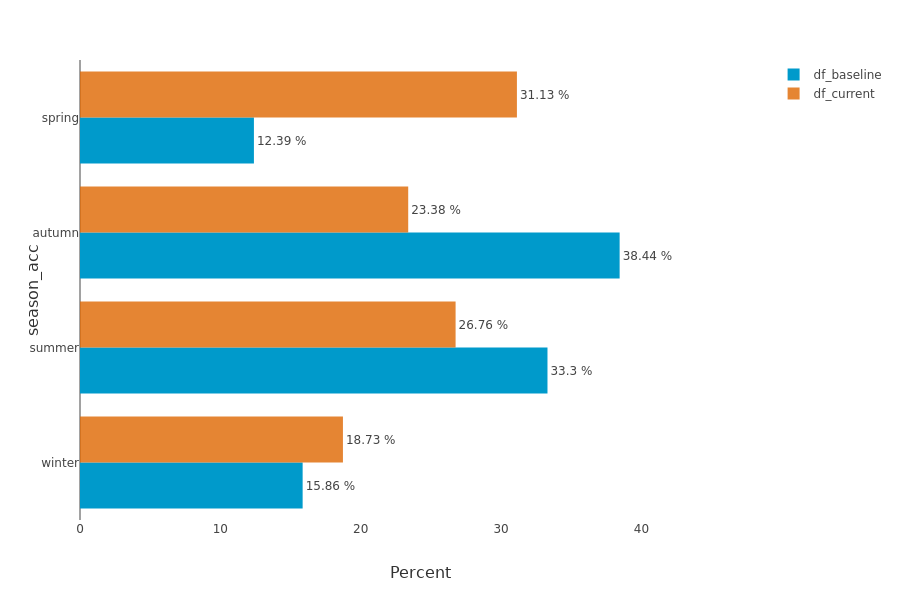

In [22]:
SD.plot.generate_fig_univariate('season_acc')

### Distribution of predicted values

This graph shows distributions of the production model outputs on both baseline and current datasets.

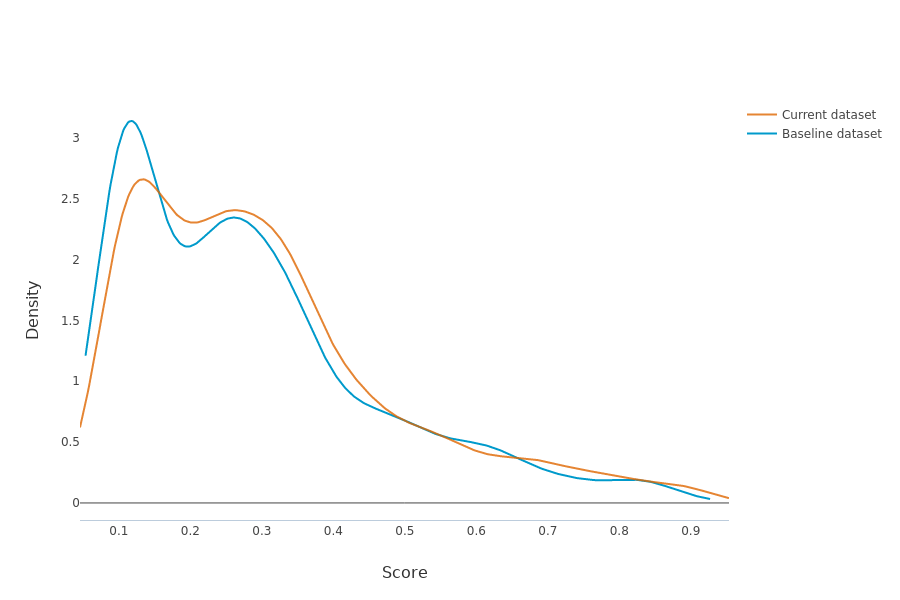

In [23]:
SD.plot.generate_fig_univariate(df_all=SD.df_predict,col='Score',hue="dataset") # works if deployed_model is filled

Jensen Shannon Divergence (JSD). The JSD measures the effect of a data drift on the deployed model performance. A value close to 0 indicates similar data distributions, while a value close to 1 tend to indicate distinct data distributions with a negative effect on the deployed model performance.

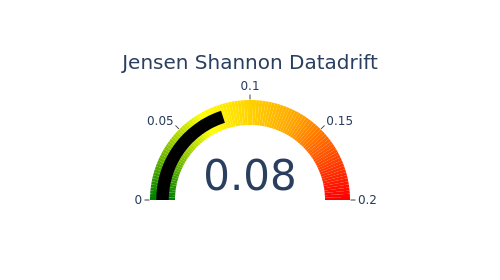

In [24]:
SD.plot.generate_indicator(
                fig_value=SD.js_divergence,
                height=280,
                width=500,
                title="Jensen Shannon Datadrift",
                min_gauge=0,
                max_gauge=0.2,
            ) #works if deployed_model is filled

## Compile Drift over years

### Compile Drift et generate report for Year 2018

In [25]:
SD = SmartDrift(df_current=X_df_2018,
                df_baseline=X_df_learning,
                deployed_model=model, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [26]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = '01/01/2018', # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "car_accident_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.6911612512986636


----

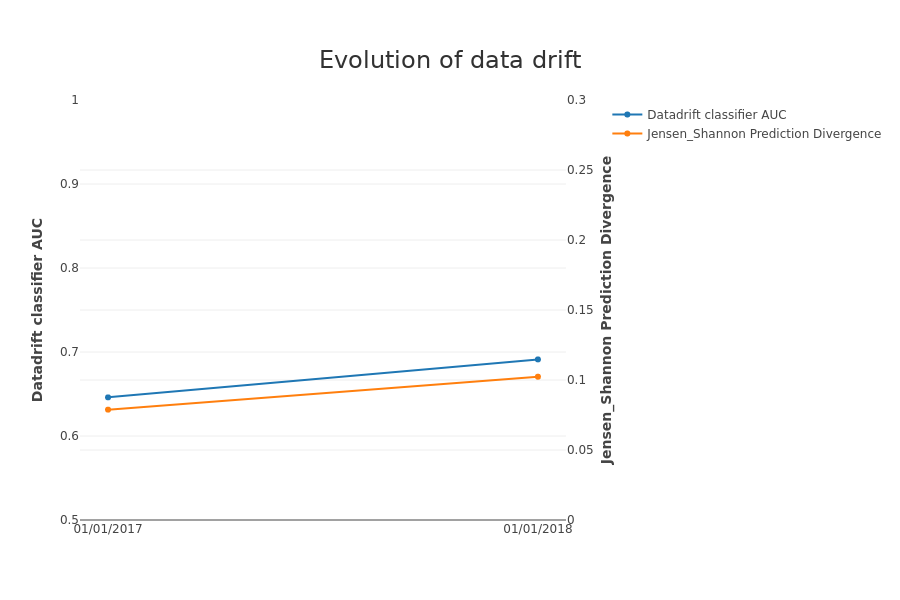

In [27]:
SD.plot.generate_historical_datadrift_metric() # works if date_compile_auc and/or datadrift_file are filled

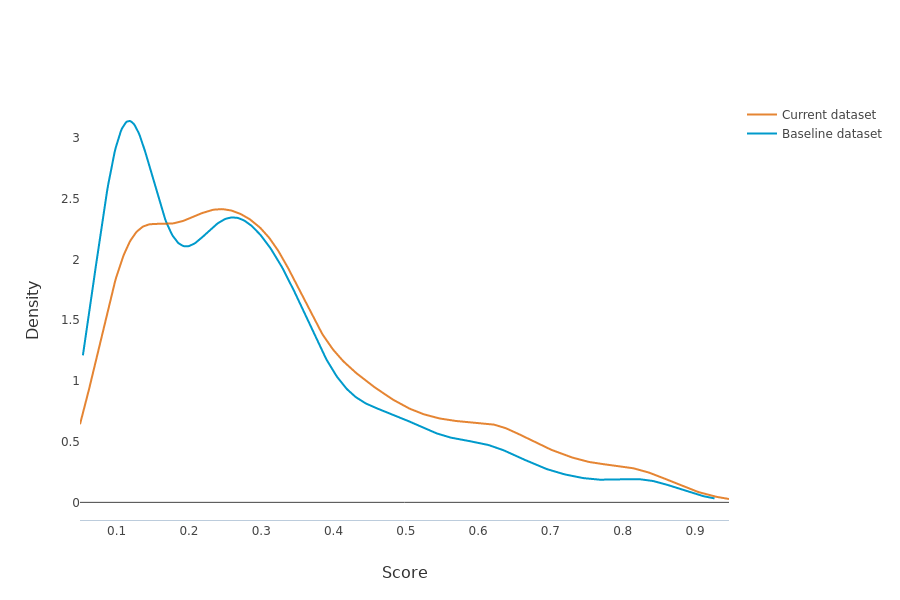

In [28]:
SD.plot.generate_fig_univariate(df_all=SD.df_predict,col='Score',hue="dataset") # works if deployed_model is filled

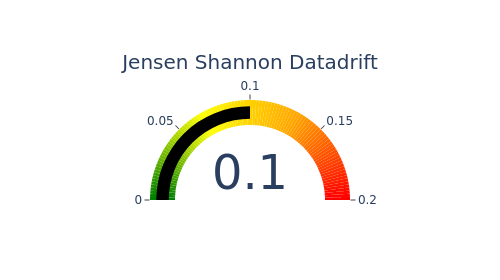

In [29]:
SD.plot.generate_indicator(
                fig_value=SD.js_divergence,
                height=280,
                width=500,
                title="Jensen Shannon Datadrift",
                min_gauge=0,
                max_gauge=0.2,
            ) # works if deployed_model is filled

------

### Compile Drift et generate report for Year 2019

In [30]:
SD = SmartDrift(df_current=X_df_2019,
                df_baseline=X_df_learning,
                deployed_model=model, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [31]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = '01/01/2019', # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "car_accident_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.9131375742708316


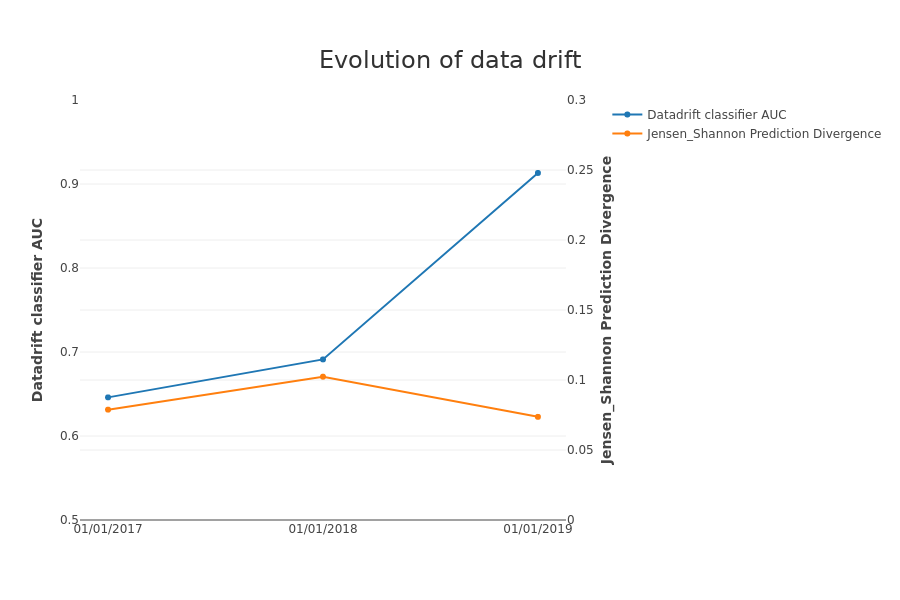

In [32]:
SD.plot.generate_historical_datadrift_metric() # works if date_compile_auc and/or datadrift_file are filled

This result is interesting because we see that the auc is very high, but not the Jensen Shannon datadrift. This shows the interest of the latter.

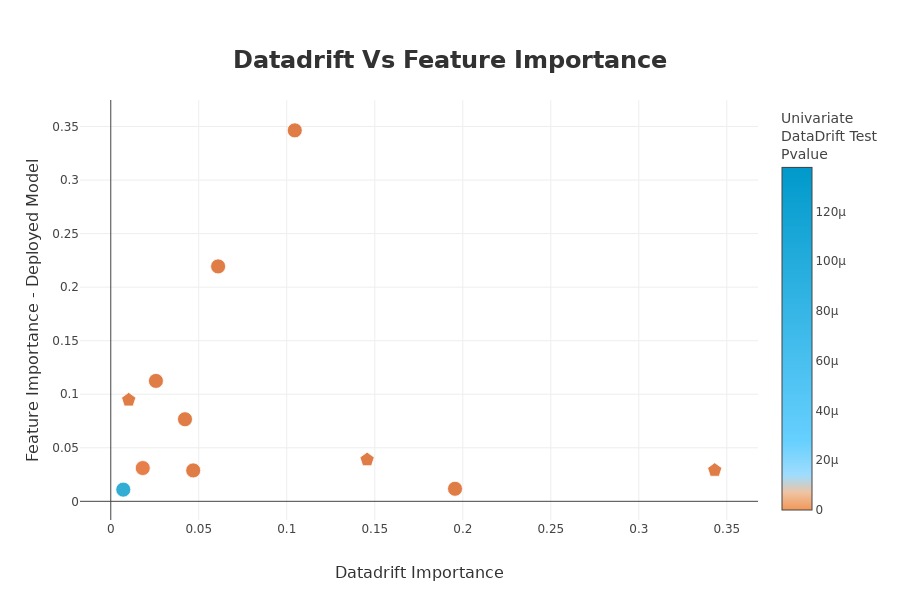

In [33]:
SD.plot.scatter_feature_importance() # works if deployed_model is filled

the first 3 variables that explain the data drift by the auc of datadrift classifier are not very important for the model

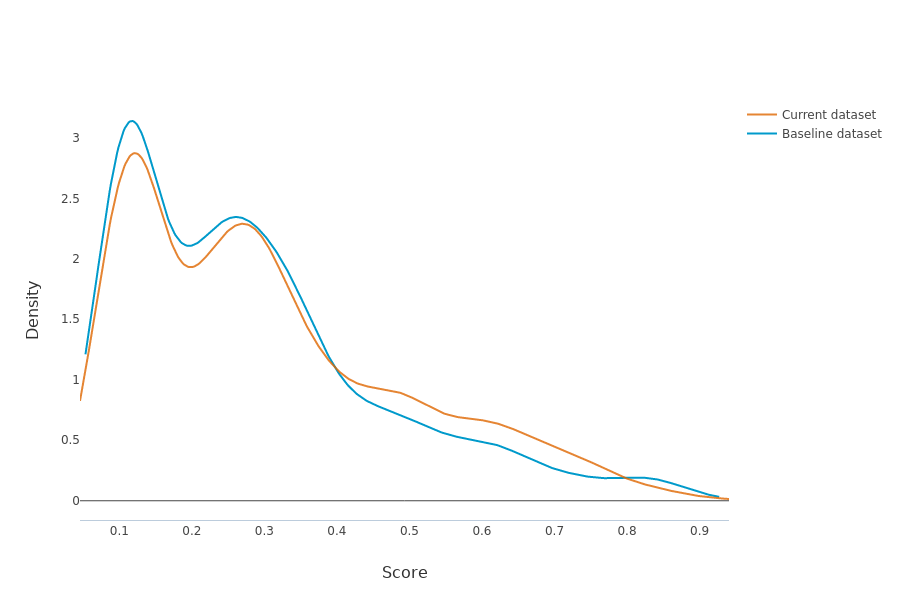

In [34]:
SD.plot.generate_fig_univariate(df_all=SD.df_predict,col='Score',hue="dataset") # works if deployed_model is filled

We can see that despite the data drift, the impact on predictions is quite small

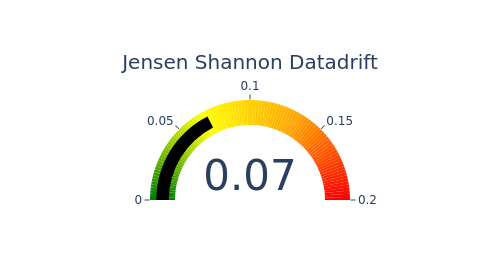

In [35]:
SD.plot.generate_indicator(
                fig_value=SD.js_divergence,
                height=280,
                width=500,
                title="Jensen Shannon Datadrift",
                min_gauge=0,
                max_gauge=0.2,
            ) # works if deployed_model is filled

### Compile Drift et generate report for Year 2020

In [36]:
SD = SmartDrift(df_current=X_df_2020,
                df_baseline=X_df_learning,
                deployed_model=model, # Optional: put in perspective result with importance on deployed model
                encoding=encoder # Optional: if deployed_model and encoder to use this model
               )

In [37]:
SD.compile(full_validation=True, # Optional: to save time, leave the default False value. If True, analyze consistency on modalities between columns.
           date_compile_auc = '01/01/2020', # Optional: useful when computing the drift for a time that is not now
           datadrift_file = "car_accident_auc.csv" # Optional: name of the csv file that contains the performance history of data drift
          )

The variable Weather_Condition has mismatching unique values:
[] | ['Overcast', 'Clear', 'Scattered Clouds']

The computed AUC on the X_test used to build datadrift_classifier is equal to: 0.9358807623200552


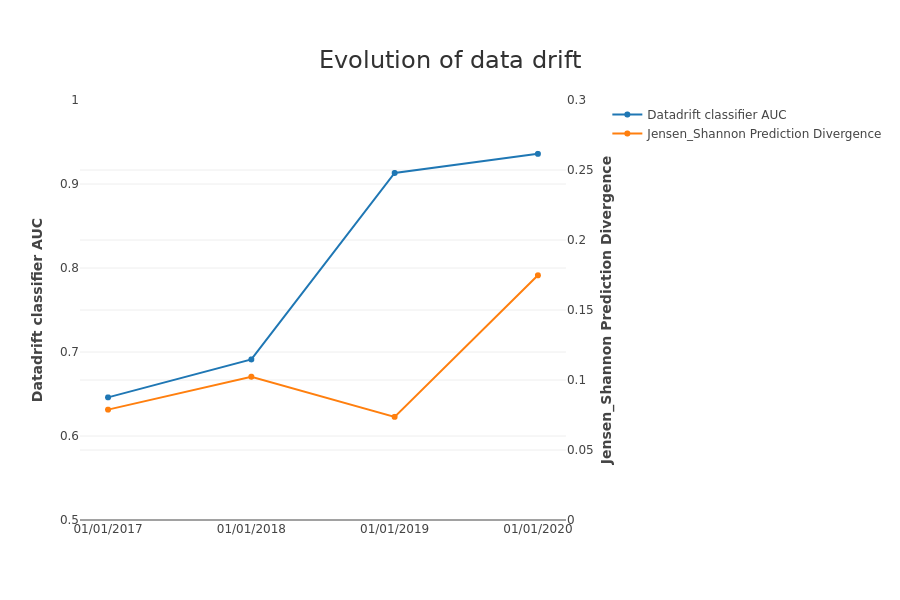

In [38]:
SD.plot.generate_historical_datadrift_metric() # works if date_compile_auc and/or datadrift_file are filled

In [39]:
SD.generate_report(    
    output_file='report_car_accident_datadrift_2020.html',    
    title_story="Data drift",
    title_description="""Car accident Data drift 2020""", # Optional: add a subtitle to describe report
    project_info_file="../../eurybia/data/project_info_car_accident.yml" # Optional: add information on report
    )

Report saved to ./report_car_accident_datadrift_2020.html. To upload and share your report, create a free Datapane account by running `!datapane signup`.